<a href="https://colab.research.google.com/github/abdulwasaeee/reinforcement-learning-course/blob/main/q-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import time

import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
id= "CartPole-v1"
n= 1
timesteps= 100000
learningrate= 1e-3
gamma= 0.99  #discount factor
eps= 0.1     #epsilon-greedy
seed= None
path="videos"

In [3]:
def make_env(id, video, seed=None):
  if video:
    env= gym.make(id, render_mode="rgb_array")
    env= gym.wrappers.RecordVideo(env, path, episode_trigger= lambda episode: True)

  else:
    env= gym.make(id)
    env= gym.wrappers.RecordEpisodeStatistics(env)

  if seed is not None:
    env.action_space(seed)
  return env

In [4]:
class QN(nn.Module):
  def __init__(self, envs, hidden=128):
    super().__init__()
    self.network= nn.Sequential(
        nn.Linear(np.array(envs.single_observation_space.shape).prod(), hidden),
        nn.ReLU(),
        nn.Linear(hidden, envs.single_action_space.n)
    )

  def forward(self,x):
    return self.network(x)

In [5]:
envs= gym.vector.SyncVectorEnv([
    lambda: make_env(
        id,
        video= False,
        seed=seed if seed is None else seed + i)
    for i in range(n)
])

In [6]:
device= torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [7]:
device

device(type='cpu')

In [8]:
qn= QN(envs).to(device)
opt= optim.Adam(qn.parameters(), lr=learningrate)

In [9]:
def n2t(a):
  return torch.Tensor(a).float().to(device)

In [10]:
epreturns= []
losses= []

start=time.time()
obs, _ = envs.reset(seed=seed)
autoreset= np.zeros(n, dtype=bool)

for globalstep in range(timesteps):
  if random.random() < eps:
    actions= np.array(
        [envs.single_action_space.sample() for _ in range(n)]
    )
  else:
    qvalues= qn(n2t(obs))
    actions= torch.argmax(qvalues, dim=1).cpu().numpy()

  nextobs, rewards, terminateds, truncateds, infos= envs.step(actions)

  for i, (terminated,truncated) in enumerate(zip(terminateds,truncateds)):
       if terminated or truncated:
          ret= infos['episode']['r'][i]
          epreturns.append(ret)
          print(f"global step= {globalstep}, episode={len(epreturns)}, episode returns= {ret}")

  mask= np.logical_not(autoreset)
  obs_= obs[mask]
  actions_= actions[mask]
  rewards_= rewards[mask]
  nextobs_= nextobs[mask]
  terminateds_= terminateds[mask] | truncateds[mask]
  if np.any(mask):
    with torch.no_grad():
      qnext, _= qn(n2t(nextobs_)).max(dim=1)
      target= n2t(rewards_) + gamma* (1-n2t(terminateds_)) * qnext
    pred= qn(n2t(obs_)).gather(1, torch.from_numpy(actions_.reshape(1,1)).to(device))

    loss= F.mse_loss(target.squeeze(), pred.squeeze())
    losses.append(loss.detach().cpu().numpy())

    opt.zero_grad()
    loss.backward()
    opt.step()

  obs=nextobs
  autoreset=np.logical_or(terminateds, truncateds)
  if globalstep% 1000 ==0:
    print("steps per second:", int(globalstep/ (time.time()- start)))

  if len(epreturns)>10 and np.all(np.equal(epreturns[-10:], 500)):
    print("max reward acheived")
    break



steps per second: 0
global step= 7, episode=1, episode returns= 8.0
global step= 16, episode=2, episode returns= 8.0
global step= 27, episode=3, episode returns= 10.0
global step= 37, episode=4, episode returns= 9.0
global step= 48, episode=5, episode returns= 10.0
global step= 61, episode=6, episode returns= 12.0
global step= 71, episode=7, episode returns= 9.0
global step= 82, episode=8, episode returns= 10.0
global step= 92, episode=9, episode returns= 9.0
global step= 104, episode=10, episode returns= 11.0
global step= 114, episode=11, episode returns= 9.0
global step= 124, episode=12, episode returns= 9.0
global step= 134, episode=13, episode returns= 9.0
global step= 146, episode=14, episode returns= 11.0
global step= 155, episode=15, episode returns= 8.0
global step= 166, episode=16, episode returns= 10.0
global step= 176, episode=17, episode returns= 9.0
global step= 189, episode=18, episode returns= 12.0
global step= 200, episode=19, episode returns= 10.0
global step= 211, epi

In [11]:
envs.close()

In [22]:
len(epreturns)

1121

In [12]:
def smooth(x, a=0.1):
  y=[x[0]]
  for xi in x[1:]:
    yi= a* xi + (1-a) * y[-1]
    y.append(yi)
  return y

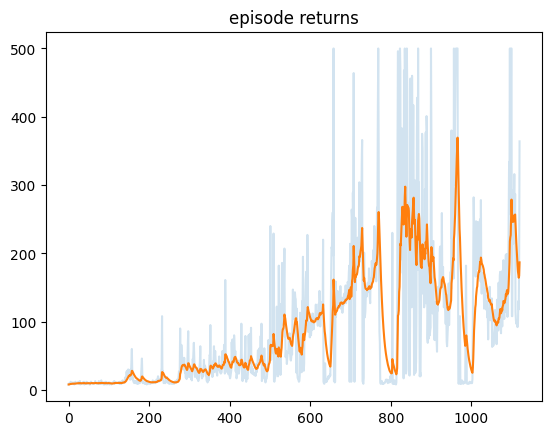

In [23]:
plt.plot(epreturns, alpha=0.2)
plt.plot(smooth(epreturns))
plt.title("episode returns")
plt.show()

In [24]:
autoreset

array([False])